# Neural Net Model for Sentence Categorization

A Neural Network model to help classify sentences as important, or not important enough to be part of a summary

Built using Keras

https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

Using TensorFlow backend.


In [2]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
sentence_vectors_filename = join(FEATURES_DIR, "sentence_vectors.csv")
summarized_chat_log_ids_filename = join(DATA_FILES_DIR, "summarized_chat_log_ids.csv")
summarized_chat_date_partitions_filename = join(
    DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv"
)
concatenated_vectors_filename = join(DATA_FILES_DIR, "summarized_concatenated_vectors_window_5.csv")

In [3]:
# read in data using pandas. This takes a couple of seconds
# sentence_vectors_df = pd.read_csv(sentence_vectors_filename)

In [4]:
print(sentence_vectors_df.shape)
sentence_vectors_df.head()

(659165, 150)


,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,2.661401e-11,4.864283e-10,2.155568e-09,2.559706e-09,2.042709e-09,-9.672571e-10,-1.011755e-09,-7.997459e-10,4.663964e-10,9.187571e-10,...,1.407428e-10,2.914283e-09,-2.747660e-10,4.775819e-10,-2.102210e-10,2.105973e-09,1.021558e-09,2.252703e-10,1.863019e-10,8.672187e-10
1,1.022276e-10,-1.955946e-09,1.327970e-09,1.232455e-09,2.482607e-09,-2.743914e-10,-1.086364e-09,-2.488646e-10,1.262163e-09,9.180705e-10,...,-6.610669e-10,-1.520207e-09,8.983655e-10,8.465219e-10,3.878689e-11,2.797304e-09,1.089229e-10,1.791956e-09,7.814260e-10,-5.340539e-10
2,5.006117e-09,1.308245e-09,-1.726347e-09,-2.326718e-09,2.644977e-09,-6.860966e-09,-2.840772e-09,-1.275456e-09,-3.629866e-09,2.648799e-09,...,-4.186932e-10,-4.387442e-09,-4.779804e-09,1.756883e-09,1.552142e-09,-1.799109e-09,-2.763327e-09,-1.287349e-09,7.786218e-11,3.528413e-09
3,-6.685328e-11,-2.522545e-09,2.219794e-09,2.225063e-09,1.722988e-09,1.846407e-09,-4.757319e-10,-1.983456e-09,8.535619e-10,8.168705e-10,...,3.590122e-10,-2.089154e-09,9.565531e-10,-2.301774e-10,7.218851e-10,3.257327e-09,-9.246197e-10,1.512120e-09,2.114480e-09,9.441023e-11
4,-1.038918e-10,-3.730123e-10,-1.157119e-09,6.397932e-10,5.314133e-09,-8.230628e-09,-1.027282e-09,-5.655329e-09,-4.317935e-09,4.408029e-09,...,1.600469e-09,-3.578085e-09,-8.405977e-10,6.335257e-09,-3.260453e-09,-5.920390e-10,-2.368964e-09,-2.441857e-09,2.245674e-09,2.572043e-09


In [5]:
summarized_chat_log_ids = pd.read_csv(
    summarized_chat_log_ids_filename,
    names = ["log_id", "is_summary"]
)

In [6]:
print(summarized_chat_log_ids.shape)
print(summarized_chat_log_ids.head())
print(summarized_chat_log_ids.tail())
summarized_chat_log_ids_array = np.array(summarized_chat_log_ids.log_id)
summarized_chat_log_ids_array

(20715, 2)
   log_id  is_summary
0   85350           0
1   85351           0
2   85352           0
3   85353           0
4   85354           0
       log_id  is_summary
20710  624000           0
20711  624001           0
20712  624002           0
20713  624003           0
20714  624004           0


array([ 85350,  85351,  85352, ..., 624002, 624003, 624004])

In [7]:
summarized_sentence_vectors_df = sentence_vectors_df.filter(summarized_chat_log_ids_array, axis=0)
summarized_num_of_columns = summarized_sentence_vectors_df.shape[0]
# summarized_sentence_vectors_df["index"] = [num for num in range(summarized_num_of_columns)]
# summarized_sentence_vectors_df.set_index(["index"])
# summarized_sentence_vectors_df.reset_index
# summarized_sentence_vectors_df.insert(0, "index", range(summarized_num_of_columns))
print(summarized_sentence_vectors_df.shape)
summarized_sentence_vectors_df.tail()

(20715, 150)


,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
624000,-2.839511e-10,-5.254820e-10,1.282804e-09,2.894893e-09,5.128183e-09,1.821765e-09,5.974847e-10,2.075842e-10,4.215045e-10,1.692410e-09,...,5.091932e-10,-6.648306e-10,1.652480e-09,-2.089382e-09,-9.435743e-10,1.338131e-10,7.924803e-10,-1.113637e-09,-5.985640e-10,1.253104e-09
624001,1.444210e-09,3.307301e-09,2.111036e-09,-5.132918e-09,6.891240e-09,-6.123556e-09,2.262492e-09,2.808561e-09,4.064432e-10,-1.065157e-09,...,2.181971e-09,-2.439298e-10,-2.457866e-09,-2.707327e-09,3.744598e-09,-4.807546e-09,3.496832e-09,-1.543574e-09,3.499615e-09,2.147703e-09
624002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
624003,1.458535e-09,-5.703304e-11,-5.895193e-10,-1.133689e-09,2.171077e-10,2.118639e-09,-4.534608e-09,3.737758e-09,-1.644037e-09,-2.644024e-09,...,-2.473653e-09,2.106356e-09,3.655724e-09,-7.238658e-10,-2.371045e-09,1.605171e-09,-7.973208e-10,2.627538e-09,2.332013e-09,-3.632736e-09
624004,5.430142e-10,-2.819028e-10,-7.516691e-11,2.239415e-09,-1.150621e-09,6.923654e-10,1.881467e-09,-9.825994e-11,2.935388e-10,-7.778984e-10,...,5.997935e-10,-4.273020e-11,-6.497489e-10,4.892752e-10,-8.289923e-10,-4.780643e-10,-4.995222e-10,-1.426832e-09,-1.326889e-09,-6.566220e-10


In [8]:
summarized_chat_date_partitions = pd.read_csv(summarized_chat_date_partitions_filename)

In [9]:
summarized_chat_date_partitions.tail(8)

,min_log_id,date_of_log,chat_line_count,cumulative_count
19,473197,2001-11-07,1990,16079
20,495175,2001-11-13,1051,17130
21,497259,2001-11-14,536,17666
22,526307,2001-11-15,1053,18719
23,531627,2001-11-12,1348,20067
24,579591,2001-10-24,162,20229
25,586206,2001-10-23,165,20394
26,623684,2001-10-25,321,20715


Get the first chat log id for the third last chat date. Use the last three chat log dates for testing. The rest to be used for training

In [10]:
index_for_validation_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_validation_test_split = index_for_validation_test_split.values[0]
index_for_train_validation_split = summarized_chat_date_partitions.tail(8)["cumulative_count"]
index_for_train_validation_split = index_for_train_validation_split.values[0]
print(index_for_train_validation_split)
index_for_validation_test_split

16079


20067

Concatenate sentence vectors for context

In [13]:
def concatenate_sentence_vectors(data_values, window):
    number_of_rows, number_of_columns = data_values.shape
    eventual_number_of_columns = number_of_columns +(number_of_columns * window * 2)
    new_np_data = np.array([]).reshape(0, eventual_number_of_columns)
    
    for index in range(data_values.shape[0]):
        first_index = index - window
        last_index = index + window
        start_padding = []
        end_padding = []
        
        if first_index < 0:
            start_padding = np.zeros((abs(first_index), number_of_columns))
            first_index = 0
        if last_index >= number_of_rows:
            end_padding = np.zeros((((last_index - number_of_rows) + 1), number_of_columns))
            last_index = number_of_rows - 1
            
        concatenated_row = data_values[first_index:last_index+1]
        # print("\n", index, "\n", concatenated_row, start_padding, "\n\n")
        if len(start_padding) > 0:
            # print(start_padding.shape, data_values[first_index: first_index+1].shape)
            concatenated_row = np.concatenate((start_padding, concatenated_row))
        if len(end_padding) > 0:
            # print(end_padding.shape, data_values[first_index: first_index+1].shape)
            concatenated_row = np.concatenate((concatenated_row, end_padding))
        concatenated_row = concatenated_row.ravel()
        # print(index, concatenated_row, "\n\n")
        # print(concatenated_row.shape, new_np_data.shape)
        new_np_data = np.concatenate((new_np_data, concatenated_row))
    return pd.DataFrame(new_np_data)

In [14]:
start = time.time()
# summarized_sentence_vectors_array = summarized_sentence_vectors_df.values
context_window = 5

# This takes about 40 minutes, or 2386.799 seconds
# concatenated_sentence_vectors_df = concatenate_sentence_vectors(summarized_sentence_vectors_array, context_window)
end = time.time()
print(end - start)

4.291534423828125e-05


In [15]:
# concatenated_sentence_vectors_df = pd.read_csv(concatenated_vectors_filename)

In [16]:
# concatenated_sentence_vectors_df = concatenated_sentence_vectors_df.drop(columns=[0])
# concatenated_sentence_vectors_df.to_csv(concatenated_vectors_filename)
# concatenated_sentence_vectors_df.head(6)

In [17]:
# concatenated_sentence_vectors_df.tail(6)

In [18]:
# concatenated_sentence_vectors_df = concatenated_sentence_vectors_df.drop(columns=["Unnamed: 0"])
# concatenated_sentence_vectors_df.head(2)

In [11]:
print(summarized_sentence_vectors_df.shape)
summarized_sentence_vectors_df.tail()

(20715, 150)


,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
624000,-2.839511e-10,-5.254820e-10,1.282804e-09,2.894893e-09,5.128183e-09,1.821765e-09,5.974847e-10,2.075842e-10,4.215045e-10,1.692410e-09,...,5.091932e-10,-6.648306e-10,1.652480e-09,-2.089382e-09,-9.435743e-10,1.338131e-10,7.924803e-10,-1.113637e-09,-5.985640e-10,1.253104e-09
624001,1.444210e-09,3.307301e-09,2.111036e-09,-5.132918e-09,6.891240e-09,-6.123556e-09,2.262492e-09,2.808561e-09,4.064432e-10,-1.065157e-09,...,2.181971e-09,-2.439298e-10,-2.457866e-09,-2.707327e-09,3.744598e-09,-4.807546e-09,3.496832e-09,-1.543574e-09,3.499615e-09,2.147703e-09
624002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
624003,1.458535e-09,-5.703304e-11,-5.895193e-10,-1.133689e-09,2.171077e-10,2.118639e-09,-4.534608e-09,3.737758e-09,-1.644037e-09,-2.644024e-09,...,-2.473653e-09,2.106356e-09,3.655724e-09,-7.238658e-10,-2.371045e-09,1.605171e-09,-7.973208e-10,2.627538e-09,2.332013e-09,-3.632736e-09
624004,5.430142e-10,-2.819028e-10,-7.516691e-11,2.239415e-09,-1.150621e-09,6.923654e-10,1.881467e-09,-9.825994e-11,2.935388e-10,-7.778984e-10,...,5.997935e-10,-4.273020e-11,-6.497489e-10,4.892752e-10,-8.289923e-10,-4.780643e-10,-4.995222e-10,-1.426832e-09,-1.326889e-09,-6.566220e-10


In [12]:
FEATURES_DATA_FILE = join(FEATURES_DIR, "summarized_chats_features.csv")
# read in data using pandas
unnormalized_chat_log_df = pd.read_csv(FEATURES_DATA_FILE)

In [13]:
unnormalized_chat_log_df.tail()
# unnormalized_chat_log_df.insert(0, "index", range(unnormalized_chat_log_df.shape[0]))
# print(unnormalized_chat_log_df.loc[0:5])
unnormalized_chat_log_df.head()


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
0,85350,0.000436,1,0,0.6249,0.000789,0.006050,2.758723,0.788992,0
1,85351,0.000871,13,0,0.0000,0.003486,0.026734,0.149401,0.042729,0
2,85352,0.001307,10,0,0.0000,0.004054,0.031086,0.180867,0.051728,0
3,85353,0.001743,5,0,0.0000,0.003645,0.027952,0.499669,0.142905,0
4,85354,0.002179,8,0,0.2263,0.002310,0.017715,0.295432,0.084493,0


In [327]:
unnormalized_merged_log_data_df = pd.merge(
    unnormalized_chat_log_df, 
    summarized_sentence_vectors_df, 
    left_on="log_id",
    right_index=True
)
print(unnormalized_merged_log_data_df.shape)
unnormalized_merged_log_data_df.head()

(20715, 160)


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary,...,141,142,143,144,145,146,147,148,149,150
0,85350,0.000436,1,0,0.6249,0.000789,0.006050,2.758723,0.788992,0,...,5.032557e-08,4.709798e-09,-7.814833e-08,3.333242e-08,-1.757239e-08,-4.967683e-09,3.275183e-08,-4.288362e-08,2.537755e-09,2.285525e-08
1,85351,0.000871,13,0,0.0000,0.003486,0.026734,0.149401,0.042729,0,...,3.880125e-08,-1.505285e-08,-3.228048e-08,6.559005e-08,2.989873e-08,-2.563377e-08,-3.230809e-08,-1.410832e-08,3.297067e-08,8.902228e-08
2,85352,0.001307,10,0,0.0000,0.004054,0.031086,0.180867,0.051728,0,...,2.331976e-08,-2.124629e-08,-5.314322e-09,4.871865e-08,2.572267e-08,-1.130713e-08,-3.515117e-08,2.479115e-08,9.735289e-09,3.229467e-08
3,85353,0.001743,5,0,0.0000,0.003645,0.027952,0.499669,0.142905,0,...,2.564207e-08,1.737575e-09,2.070995e-08,-6.362434e-10,-2.201059e-08,2.865113e-08,-7.716492e-09,-3.310467e-08,-9.572791e-09,-1.052344e-08
4,85354,0.002179,8,0,0.2263,0.002310,0.017715,0.295432,0.084493,0,...,2.957617e-11,-1.465501e-10,1.223374e-10,1.708342e-10,3.674844e-10,1.448876e-10,6.751768e-10,1.813555e-10,6.316711e-10,-4.996572e-10


### Normalizing The Data
Formula to normalize data
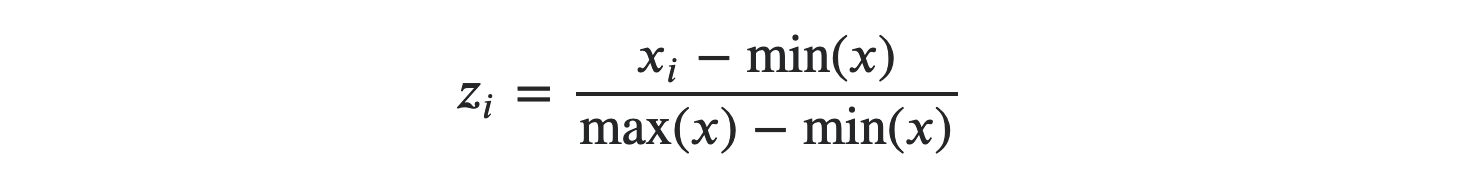

In [16]:
chat_data_max_values = unnormalized_chat_log_df.max()
chat_data_min_values = unnormalized_chat_log_df.min()
max_number_of_special_terms = chat_data_max_values.number_of_special_terms
max_sentence_length = chat_data_max_values.sentence_length
min_number_of_special_terms = chat_data_min_values.number_of_special_terms
min_sentence_length = chat_data_min_values.sentence_length

max_sentence_length

73.0

In [18]:
chat_log_df = unnormalized_chat_log_df.copy()
chat_log_df.sentence_length = (
    chat_log_df.sentence_length - min_sentence_length) / (
    max_sentence_length - min_sentence_length)
chat_log_df.number_of_special_terms = (
    chat_log_df.number_of_special_terms - min_number_of_special_terms) / (
    max_number_of_special_terms - min_number_of_special_terms)
chat_log_df.reset_index()
print(chat_log_df.sentence_length.head())
chat_log_df.iloc[0:5]
# chat_log_df.head()

0    0.013699
1    0.178082
2    0.136986
3    0.068493
4    0.109589
Name: sentence_length, dtype: float64


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
0,85350,0.000436,0.013699,0.0,0.6249,0.000789,0.006050,2.758723,0.788992,0
1,85351,0.000871,0.178082,0.0,0.0000,0.003486,0.026734,0.149401,0.042729,0
2,85352,0.001307,0.136986,0.0,0.0000,0.004054,0.031086,0.180867,0.051728,0
3,85353,0.001743,0.068493,0.0,0.0000,0.003645,0.027952,0.499669,0.142905,0
4,85354,0.002179,0.109589,0.0,0.2263,0.002310,0.017715,0.295432,0.084493,0


In [20]:
train_df = chat_log_df.iloc[:index_for_train_validation_split]
validation_df = chat_log_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
test_df = chat_log_df.iloc[index_for_validation_test_split:]
train_df.tail()

# Sentence Vectors only
# train_vectors_df = summarized_sentence_vectors_df.iloc[:index_for_train_validation_split]
# validation_vectors_df = summarized_sentence_vectors_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
# test_vectors_df = summarized_sentence_vectors_df.iloc[index_for_validation_test_split:]
# train_vectors_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
16074,475182,0.997990,0.136986,0.0,0.2023,0.003331,0.025540,0.200114,0.057232,0
16075,475183,0.998492,0.013699,0.0,0.0000,0.002157,0.016537,2.395763,0.685186,0
16076,475184,0.998995,0.027397,0.0,0.2263,0.002054,0.015752,0.906608,0.259289,0
16077,475185,0.999497,0.013699,0.0,0.6369,0.004502,0.034522,1.754785,0.501867,0
16078,475186,1.000000,0.082192,0.0,0.2240,0.003923,0.030084,0.269295,0.077018,0


In [21]:
validation_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
16079,495175,0.000951,0.150685,0.000000,0.4588,0.002049,0.015712,0.174116,0.049797,0
16080,495176,0.001903,0.013699,0.000000,0.0000,0.000825,0.006325,3.021603,0.864176,0
16081,495177,0.002854,0.000000,0.000000,0.4588,0.000000,0.000000,0.000000,0.000000,0
16082,495178,0.003806,0.136986,0.054054,0.0000,0.001636,0.012544,0.212884,0.060885,0
16083,495179,0.004757,0.054795,0.000000,0.4588,0.001551,0.011894,0.442957,0.126685,0


In [22]:
validation_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20062,532970,0.997033,0.013699,0.0,0.0000,0.001777,0.013628,3.129690,0.895088,0
20063,532971,0.997774,0.041096,0.0,0.0000,0.004070,0.031206,0.773078,0.221100,0
20064,532972,0.998516,0.013699,0.0,0.5267,0.002360,0.018096,2.527630,0.722900,0
20065,532973,0.999258,0.068493,0.0,-0.2500,0.002685,0.020592,0.354299,0.101329,0
20066,532974,1.000000,0.027397,0.0,0.0000,0.000900,0.006898,1.144535,0.327336,0


In [23]:
test_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20067,579591,0.006173,0.232877,0.0,0.5994,0.000609,0.004672,0.100264,0.028675,0
20068,579592,0.012346,0.027397,0.0,-0.2960,0.000089,0.000686,1.104758,0.315960,0
20069,579593,0.018519,0.041096,0.0,-0.2960,0.000439,0.003367,0.642605,0.183785,0
20070,579594,0.024691,0.000000,0.0,-0.4404,0.000000,0.000000,0.000000,0.000000,0
20071,579595,0.030864,0.027397,0.0,0.0000,0.000553,0.004243,0.954243,0.272912,0


In [24]:
# check data has been read in properly
test_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987539,0.027397,0.0,0.0000,0.000432,0.003309,0.983457,0.281268,0
20711,624001,0.990654,0.054795,0.0,0.0000,0.000801,0.006145,0.444846,0.127226,0
20712,624002,0.993769,0.095890,0.0,0.5267,0.001122,0.008603,0.306102,0.087545,0
20713,624003,0.996885,0.000000,0.0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,0.013699,0.0,0.0000,0.000803,0.006161,2.205475,0.630764,0


In [25]:
#create a dataframe with all training data except the target column
columns_to_drop = ["log_id", "is_summary", "mean_tf_idf", "mean_tf_isf"]
# Keep only normalized columns
train_X = train_df.drop(columns=columns_to_drop)
validation_X = validation_df.drop(columns=columns_to_drop)
test_X = test_df.drop(columns=columns_to_drop)

assert train_X.shape[1] == test_X.shape[1] and test_X.shape[1] == validation_X.shape[1] 
#check that the target variable has been removed
print(train_X.shape)
train_X.head()

(16079, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.000436,0.013699,0.0,0.6249,0.006050,0.788992
1,0.000871,0.178082,0.0,0.0000,0.026734,0.042729
2,0.001307,0.136986,0.0,0.0000,0.031086,0.051728
3,0.001743,0.068493,0.0,0.0000,0.027952,0.142905
4,0.002179,0.109589,0.0,0.2263,0.017715,0.084493


In [38]:
vector_columns = [str(num) for num in range(1, 151)]
train_X_no_vectors = train_X.drop(columns=vector_columns)
validation_X_no_vectors = validation_X.drop(columns=vector_columns)
test_X_no_vectors = test_X.drop(columns=vector_columns)

In [39]:
print(train_X_no_vectors.shape)
assert train_X_no_vectors.shape[1] == validation_X_no_vectors.shape[1] 
assert validation_X_no_vectors.shape[1] == test_X_no_vectors.shape[1]
train_X_no_vectors.head()

(16079, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.000436,0.013699,0.0,0.6249,0.006050,0.788992
1,0.000871,0.178082,0.0,0.0000,0.026734,0.042729
2,0.001307,0.136986,0.0,0.0000,0.031086,0.051728
3,0.001743,0.068493,0.0,0.0000,0.027952,0.142905
4,0.002179,0.109589,0.0,0.2263,0.017715,0.084493


In [26]:
print(validation_X.shape)
validation_X.head()

(3988, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
16079,0.000951,0.150685,0.000000,0.4588,0.015712,0.049797
16080,0.001903,0.013699,0.000000,0.0000,0.006325,0.864176
16081,0.002854,0.000000,0.000000,0.4588,0.000000,0.000000
16082,0.003806,0.136986,0.054054,0.0000,0.012544,0.060885
16083,0.004757,0.054795,0.000000,0.4588,0.011894,0.126685


In [27]:
print(test_X.shape)
test_X.head()

(648, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20067,0.006173,0.232877,0.0,0.5994,0.004672,0.028675
20068,0.012346,0.027397,0.0,-0.2960,0.000686,0.315960
20069,0.018519,0.041096,0.0,-0.2960,0.003367,0.183785
20070,0.024691,0.000000,0.0,-0.4404,0.000000,0.000000
20071,0.030864,0.027397,0.0,0.0000,0.004243,0.272912


In [28]:
train_df.is_summary.values

array([0, 0, 0, ..., 0, 0, 0])

When separating the target column, we need to call the `to_categorical()` function so that column will be `one-hot encoded`. Currently, a chat line that is not a summary is represented with a `0` in the `is_summary` column and a chat line that is a summary is represented with a `1`. With one-hot encoding, the integer will be removed and a binary variable is inputted for each category.

In [29]:
# create a one hot encoding for the target column
train_y = to_categorical(train_df.is_summary)
train_y_nums = train_df.is_summary.values
validation_y = to_categorical(validation_df.is_summary)
validation_y_nums = validation_df.is_summary.values
test_y = to_categorical(test_df.is_summary)
test_y_nums = test_df.is_summary.values
# view one hot encoding numpy array
print(train_y_nums)
train_y[415: 425]

[0 0 0 ... 0 0 0]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [30]:
print(train_y.shape)
print(validation_y.shape)
print(test_y.shape)

(16079, 2)
(3988, 2)
(648, 2)


In [31]:
test_y[5:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

The activation is `softmax`. Softmax makes the output sum up to `1` so the output can be interpreted as probabilities. The model will then make its prediction based on which option has a higher probability.

In [37]:

#create model
model = Sequential()

#get number of columns in training data
# n_cols = train_vectors_df.shape[1]
n_cols = train_X.shape[1]

#add model layers
model.add(Dense(n_cols, activation='relu', input_shape=(n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dense(300, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 11,044
Trainable params: 11,044
Non-trainable params: 0
_________________________________________________________________


We will use `categorical_crossentropy` for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.

We will use the ‘mean absolute error’ metric to see the score on the validation set at the end of each epoch.

In [39]:
#compile model using mse as a measure of model performance
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [40]:
#set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=3)

In [41]:
#train model
# Takes about 5230.725239038467  seconds About 1 and 1/2 hours for 1000 epochs
start = time.time()
history = model.fit(
    train_X,
    # train_X_no_vectors, 
    train_y, 
    epochs=400,
    # validation_split=0.4
    validation_data=(validation_X, validation_y)
    
)
end = time.time()
print(end-start, " seconds")

Instructions for updating:
Use tf.cast instead.
Train on 16079 samples, validate on 3988 samples
Epoch 1/400
16079/16079 [==============================] - 2s 144us/step - loss: 0.1632 - acc: 0.9665 - val_loss: 0.1285 - val_acc: 0.9709
Epoch 2/400
16079/16079 [==============================] - 2s 106us/step - loss: 0.1345 - acc: 0.9684 - val_loss: 0.1320 - val_acc: 0.9709
Epoch 3/400
16079/16079 [==============================] - 1s 83us/step - loss: 0.1338 - acc: 0.9684 - val_loss: 0.1284 - val_acc: 0.9709
Epoch 4/400
16079/16079 [==============================] - 2s 99us/step - loss: 0.1336 - acc: 0.9684 - val_loss: 0.1288 - val_acc: 0.9709
Epoch 5/400
16079/16079 [==============================] - 1s 80us/step - loss: 0.1334 - acc: 0.9684 - val_loss: 0.1287 - val_acc: 0.9709
Epoch 6/400
16079/16079 [==============================] - 1s 89us/step - loss: 0.1331 - acc: 0.9684 - val_loss: 0.1291 - val_acc: 0.9709
Epoch 7/400
16079/16079 [==============================] - 2s 98us/step -

16079/16079 [==============================] - 1s 62us/step - loss: 0.1282 - acc: 0.9684 - val_loss: 0.1296 - val_acc: 0.9709
Epoch 58/400
16079/16079 [==============================] - 1s 75us/step - loss: 0.1282 - acc: 0.9684 - val_loss: 0.1307 - val_acc: 0.9709
Epoch 59/400
16079/16079 [==============================] - 1s 72us/step - loss: 0.1280 - acc: 0.9684 - val_loss: 0.1292 - val_acc: 0.9709
Epoch 60/400
16079/16079 [==============================] - 1s 68us/step - loss: 0.1279 - acc: 0.9684 - val_loss: 0.1310 - val_acc: 0.9709
Epoch 61/400
16079/16079 [==============================] - 1s 74us/step - loss: 0.1280 - acc: 0.9684 - val_loss: 0.1294 - val_acc: 0.9709
Epoch 62/400
16079/16079 [==============================] - 1s 76us/step - loss: 0.1284 - acc: 0.9684 - val_loss: 0.1291 - val_acc: 0.9709
Epoch 63/400
16079/16079 [==============================] - 1s 62us/step - loss: 0.1279 - acc: 0.9684 - val_loss: 0.1294 - val_acc: 0.9709
Epoch 64/400
16079/16079 [==============

Epoch 116/400
16079/16079 [==============================] - 1s 69us/step - loss: 0.1249 - acc: 0.9684 - val_loss: 0.1328 - val_acc: 0.9709
Epoch 117/400
16079/16079 [==============================] - 1s 68us/step - loss: 0.1247 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 118/400
16079/16079 [==============================] - 1s 78us/step - loss: 0.1251 - acc: 0.9684 - val_loss: 0.1331 - val_acc: 0.9709
Epoch 119/400
16079/16079 [==============================] - 1s 69us/step - loss: 0.1250 - acc: 0.9684 - val_loss: 0.1324 - val_acc: 0.9709
Epoch 120/400
16079/16079 [==============================] - 1s 64us/step - loss: 0.1241 - acc: 0.9684 - val_loss: 0.1315 - val_acc: 0.9709
Epoch 121/400
16079/16079 [==============================] - 1s 64us/step - loss: 0.1244 - acc: 0.9684 - val_loss: 0.1340 - val_acc: 0.9709
Epoch 122/400
16079/16079 [==============================] - 1s 77us/step - loss: 0.1243 - acc: 0.9684 - val_loss: 0.1328 - val_acc: 0.9709
Epoch 123/400
16079/

16079/16079 [==============================] - 1s 72us/step - loss: 0.1225 - acc: 0.9685 - val_loss: 0.1370 - val_acc: 0.9709
Epoch 175/400
16079/16079 [==============================] - 1s 70us/step - loss: 0.1220 - acc: 0.9685 - val_loss: 0.1396 - val_acc: 0.9707
Epoch 176/400
16079/16079 [==============================] - 1s 66us/step - loss: 0.1224 - acc: 0.9685 - val_loss: 0.1379 - val_acc: 0.9707
Epoch 177/400
16079/16079 [==============================] - 1s 79us/step - loss: 0.1221 - acc: 0.9685 - val_loss: 0.1377 - val_acc: 0.9707
Epoch 178/400
16079/16079 [==============================] - 1s 72us/step - loss: 0.1220 - acc: 0.9685 - val_loss: 0.1378 - val_acc: 0.9709
Epoch 179/400
16079/16079 [==============================] - 1s 69us/step - loss: 0.1219 - acc: 0.9685 - val_loss: 0.1370 - val_acc: 0.9707
Epoch 180/400
16079/16079 [==============================] - 1s 70us/step - loss: 0.1218 - acc: 0.9686 - val_loss: 0.1384 - val_acc: 0.9707
Epoch 181/400
16079/16079 [=======

16079/16079 [==============================] - 1s 64us/step - loss: 0.1199 - acc: 0.9687 - val_loss: 0.1451 - val_acc: 0.9707
Epoch 233/400
16079/16079 [==============================] - 1s 68us/step - loss: 0.1197 - acc: 0.9687 - val_loss: 0.1424 - val_acc: 0.9707
Epoch 234/400
16079/16079 [==============================] - 1s 58us/step - loss: 0.1201 - acc: 0.9687 - val_loss: 0.1470 - val_acc: 0.9707
Epoch 235/400
16079/16079 [==============================] - 1s 61us/step - loss: 0.1201 - acc: 0.9687 - val_loss: 0.1399 - val_acc: 0.9704
Epoch 236/400
16079/16079 [==============================] - 1s 57us/step - loss: 0.1206 - acc: 0.9685 - val_loss: 0.1416 - val_acc: 0.9707
Epoch 237/400
16079/16079 [==============================] - 1s 60us/step - loss: 0.1200 - acc: 0.9686 - val_loss: 0.1437 - val_acc: 0.9704
Epoch 238/400
16079/16079 [==============================] - 1s 63us/step - loss: 0.1195 - acc: 0.9686 - val_loss: 0.1470 - val_acc: 0.9707
Epoch 239/400
16079/16079 [=======

16079/16079 [==============================] - 1s 64us/step - loss: 0.1176 - acc: 0.9688 - val_loss: 0.1518 - val_acc: 0.9704
Epoch 291/400
16079/16079 [==============================] - 1s 73us/step - loss: 0.1180 - acc: 0.9688 - val_loss: 0.1519 - val_acc: 0.9707
Epoch 292/400
16079/16079 [==============================] - 1s 71us/step - loss: 0.1178 - acc: 0.9687 - val_loss: 0.1463 - val_acc: 0.9702
Epoch 293/400
16079/16079 [==============================] - 1s 65us/step - loss: 0.1176 - acc: 0.9688 - val_loss: 0.1495 - val_acc: 0.9707
Epoch 294/400
16079/16079 [==============================] - 1s 75us/step - loss: 0.1176 - acc: 0.9687 - val_loss: 0.1547 - val_acc: 0.9704
Epoch 295/400
16079/16079 [==============================] - 1s 75us/step - loss: 0.1177 - acc: 0.9687 - val_loss: 0.1555 - val_acc: 0.9707
Epoch 296/400
16079/16079 [==============================] - 1s 65us/step - loss: 0.1173 - acc: 0.9688 - val_loss: 0.1480 - val_acc: 0.9697
Epoch 297/400
16079/16079 [=======

16079/16079 [==============================] - 1s 65us/step - loss: 0.1161 - acc: 0.9687 - val_loss: 0.1493 - val_acc: 0.9699
Epoch 349/400
16079/16079 [==============================] - 1s 69us/step - loss: 0.1158 - acc: 0.9690 - val_loss: 0.1501 - val_acc: 0.9699
Epoch 350/400
16079/16079 [==============================] - 1s 75us/step - loss: 0.1161 - acc: 0.9688 - val_loss: 0.1559 - val_acc: 0.9699
Epoch 351/400
16079/16079 [==============================] - 1s 65us/step - loss: 0.1145 - acc: 0.9690 - val_loss: 0.1559 - val_acc: 0.9697
Epoch 352/400
16079/16079 [==============================] - 1s 71us/step - loss: 0.1157 - acc: 0.9687 - val_loss: 0.1587 - val_acc: 0.9697
Epoch 353/400
16079/16079 [==============================] - 1s 74us/step - loss: 0.1167 - acc: 0.9688 - val_loss: 0.1560 - val_acc: 0.9704
Epoch 354/400
16079/16079 [==============================] - 1s 66us/step - loss: 0.1158 - acc: 0.9687 - val_loss: 0.1572 - val_acc: 0.9702
Epoch 355/400
16079/16079 [=======

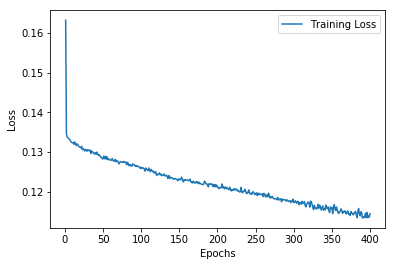

In [42]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

https://www.kaggle.com/akashsri99/deep-learning-iris-dataset-keras

In [43]:
test_y_predictions = model.predict(test_X)

In [44]:
test_y_predictions[:10]

array([[9.2734563e-01, 7.2654426e-02],
       [1.0000000e+00, 8.1595126e-33],
       [1.0000000e+00, 1.0054267e-17],
       [1.0000000e+00, 3.1066625e-22],
       [9.9933606e-01, 6.6390319e-04],
       [1.0000000e+00, 1.0092078e-17],
       [1.0000000e+00, 8.1388003e-35],
       [1.0000000e+00, 1.6771973e-15],
       [1.0000000e+00, 6.1175647e-09],
       [9.5507628e-01, 4.4923704e-02]], dtype=float32)

In [45]:
test_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [46]:
y_test_class = np.argmax(test_y,axis=1)
y_pred_class = np.argmax(test_y_predictions,axis=1)

y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
y_test_class[:20]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
y_pred_class.shape

(648,)

In [49]:
assert y_test_class.shape == y_pred_class.shape

### Imbalanced classification problem
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/
This happens because Machine Learning Algorithms are usually designed to improve accuracy by reducing the error. Thus, they do not take into account the class distribution / proportion or balance of classes.

[A Review of Class Imbalance Problem (Shaza M. Abd Elrahman and Ajith Abraham)](http://ias04.softcomputing.net/jnic2.pdf)

In [50]:
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       619
           1       0.00      0.00      0.00        29

   micro avg       0.95      0.95      0.95       648
   macro avg       0.48      0.50      0.49       648
weighted avg       0.91      0.95      0.93       648

[[618   1]
 [ 29   0]]


## Using a Recurrent Neural Network Instead
It seems that adding sentence vectors as windows around the sentence does not work well with a feed forward neural network

In [153]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [283]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [294]:
print(X_train.shape)
print(len(X_train[0]))
print(X_test.shape)
X_train[0]

(25000,)
218
(25000,)


[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 2,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 

In [288]:
print(y_train.shape)
y_train

(25000,)


array([1, 0, 0, ..., 0, 1, 0])

In [295]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [296]:
print(X_train.shape)
X_train[:5]

(25000, 500)


array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       [ 687,   23,    4, ...,   21,   64, 2574],
       [   0,    0,    0, ...,    7,   61,  113]], dtype=int32)

In [292]:
print(y_train.shape)
y_train[:5]

(25000,)


array([1, 0, 0, 1, 0])

In [297]:
print(X_test.shape)
X_test[0]

(25000, 500)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [159]:
# create the model
embedding_vecor_length = 32
imdb_model = Sequential()
imdb_model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
imdb_model.add(LSTM(100))
imdb_model.add(Dense(1, activation='sigmoid'))
imdb_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(imdb_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_36 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
imdb_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 204s 8ms/step - loss: 0.5887 - acc: 0.6728 - val_loss: 0.5178 - val_acc: 0.7478
Epoch 2/3
25000/25000 [==============================] - 193s 8ms/step - loss: 0.3717 - acc: 0.8384 - val_loss: 0.3916 - val_acc: 0.8476
Epoch 3/3
25000/25000 [==============================] - 195s 8ms/step - loss: 0.2686 - acc: 0.8935 - val_loss: 0.3383 - val_acc: 0.8628


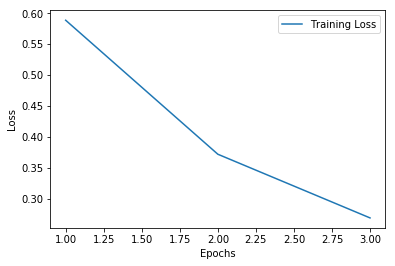

In [162]:
imdb_loss_values = imdb_history.history['loss']
imdb_epochs = range(1, len(imdb_loss_values)+1)

plt.plot(imdb_epochs, imdb_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [223]:
from keras.layers import LSTM, Dropout

In [64]:
print(train_X.shape)
train_X.head()

(16079, 156)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf,1,2,3,4,...,141,142,143,144,145,146,147,148,149,150
0,0.000436,0.013699,0.0,0.6249,0.006050,0.788992,8.923999e-08,-7.957217e-09,-5.274117e-09,-1.910836e-08,...,5.032557e-08,4.709798e-09,-7.814833e-08,3.333242e-08,-1.757239e-08,-4.967683e-09,3.275183e-08,-4.288362e-08,2.537755e-09,2.285525e-08
1,0.000871,0.178082,0.0,0.0000,0.026734,0.042729,1.138727e-09,-1.818176e-08,4.798956e-09,-5.157600e-08,...,3.880125e-08,-1.505285e-08,-3.228048e-08,6.559005e-08,2.989873e-08,-2.563377e-08,-3.230809e-08,-1.410832e-08,3.297067e-08,8.902228e-08
2,0.001307,0.136986,0.0,0.0000,0.031086,0.051728,-4.177528e-09,-1.188295e-08,2.389462e-08,-1.349990e-08,...,2.331976e-08,-2.124629e-08,-5.314322e-09,4.871865e-08,2.572267e-08,-1.130713e-08,-3.515117e-08,2.479115e-08,9.735289e-09,3.229467e-08
3,0.001743,0.068493,0.0,0.0000,0.027952,0.142905,-2.529559e-09,-1.465508e-08,8.994467e-09,8.784771e-09,...,2.564207e-08,1.737575e-09,2.070995e-08,-6.362434e-10,-2.201059e-08,2.865113e-08,-7.716492e-09,-3.310467e-08,-9.572791e-09,-1.052344e-08
4,0.002179,0.109589,0.0,0.2263,0.017715,0.084493,-2.828828e-10,4.331747e-10,8.529943e-11,-2.281351e-10,...,2.957617e-11,-1.465501e-10,1.223374e-10,1.708342e-10,3.674844e-10,1.448876e-10,6.751768e-10,1.813555e-10,6.316711e-10,-4.996572e-10


In [279]:
# A many to many RNN
#get number of columns in training data
embedding_vector_length = 32
num_of_cols = train_vectors_df.shape[1]
rnn_model = Sequential()
# rnn_model.add(Dense(num_of_cols, activation='relu', input_shape=(num_of_cols, 1)))
rnn_model.add(Embedding(train_vectors_df.shape[0], embedding_vector_length, input_length=num_of_cols))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(100))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

In [281]:
rnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 150, 32)           514528    
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 101       
Total params: 567,829
Trainable params: 567,829
Non-trainable params: 0
_________________________________________________________________


In [272]:
# rnn_history = rnn_model.fit(train_X, train_y, epochs=3, batch_size=64)
rnn_start = time.time()
rnn_history = rnn_model.fit(
    train_vectors_df, 
    train_y_nums, 
    validation_data=(validation_vectors_df, validation_y_nums), 
    epochs=10, 
    batch_size=64
)
rnn_end = time.time()
print(rnn_end - rnn_start, "seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/10
16079/16079 [==============================] - 35s 2ms/step - loss: 0.1416 - acc: 0.9684 - val_loss: 0.1325 - val_acc: 0.9709
Epoch 2/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1414 - acc: 0.9684 - val_loss: 0.1323 - val_acc: 0.9709
Epoch 3/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1413 - acc: 0.9684 - val_loss: 0.1333 - val_acc: 0.9709
Epoch 4/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1415 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 5/10
16079/16079 [==============================] - 35s 2ms/step - loss: 0.1413 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 6/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1410 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 7/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1409 - acc: 0.9684 - val_loss: 0.1321 - val_acc:

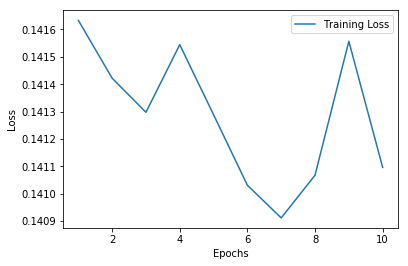

In [273]:
rnn_loss_values = rnn_history.history['loss']
rnn_epochs = range(1, len(rnn_loss_values)+1)

plt.plot(rnn_epochs, rnn_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [274]:
rnn_test_y_predictions = rnn_model.predict(validation_vectors_df)

In [275]:
rnn_test_y_predictions[:]

array([[0.03626591],
       [0.03626591],
       [0.03626591],
       ...,
       [0.03626592],
       [0.03626592],
       [0.03626592]], dtype=float32)

In [276]:
validation_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [277]:
rnn_y_test_class = np.argmax(test_y,axis=1)
rnn_y_pred_class = np.argmax(rnn_test_y_predictions,axis=1)

assert y_test_class.shape == y_pred_class.shape
print(rnn_y_pred_class.shape)
print(rnn_y_pred_class)

(3988,)
[0 0 0 ... 0 0 0]


In [278]:
print(classification_report(validation_y_nums,rnn_y_pred_class))
print(confusion_matrix(validation_y_nums,rnn_y_pred_class))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3872
           1       0.00      0.00      0.00       116

   micro avg       0.97      0.97      0.97      3988
   macro avg       0.49      0.50      0.49      3988
weighted avg       0.94      0.97      0.96      3988

[[3872    0]
 [ 116    0]]


In [ ]:
# rnn_history = rnn_model.fit(train_X, train_y, epochs=3, batch_size=64)
rnn_start = time.time()
rnn_history = rnn_model.fit(
    train_X, 
    train_y_nums, 
    validation_data=(validation_X, validation_y_nums), 
    epochs=100, 
    batch_size=64
)
rnn_end = time.time()
print(rnn_end - rnn_start, "seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
 9728/16079 [=================>............] - ETA: 14s - loss: 0.1351 - acc: 0.9704